In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import keras
import cv2
from skimage.filters import roberts, sobel

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
scaler = MinMaxScaler()
X = train_data.drop(['label'],1)
# X = scaler.fit_transform(X)
y = train_data['label']
y = to_categorical(y, num_classes=10)
print("X_train", X.shape)
print("y_train", y.shape)

X_train (42000, 784)
y_train (42000, 10)


In [4]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
# test_data = scaler.fit_transform(test_data)
print("Test data: ", test_data.shape)

Test data:  (28000, 784)


In [5]:
# Create Validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

In [6]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (33600, 784)
y_train:  (33600, 10)
X_val:  (8400, 784)
y_val:  (8400, 10)


In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

In [8]:
im_kernel = np.ones((3,3), np.uint8)
def ApplyEdgeDetection(data):  
    kernel_sharpening = np.array([[-1,-1,-1], [-1, 10,-1],[-1,-1,-1]])
    kernel_sharpening2 = np.array([[0,-1,0], [-1, 12,-1],[0,-1,0]])
    edge_data = []
    for i in data:
        sharpened = cv2.filter2D(np.uint8(i[:,:,0]),-1, kernel_sharpening)
        ret, threshold_img = cv2.threshold(sharpened, 70,255, cv2.THRESH_BINARY)
        edge_data.append(threshold_img)
    return np.array(edge_data)

X_train = ApplyEdgeDetection(X_train)
X_val = ApplyEdgeDetection(X_val)
test_data = ApplyEdgeDetection(test_data)


In [9]:
# print(X_train[0])

In [10]:
X_train = scaler.fit_transform(X_train.reshape(-1, 28*28))
X_val = scaler.fit_transform(X_val.reshape(-1, 28*28))
test_data = scaler.fit_transform(test_data.reshape(-1, 28*28))

X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (33600, 28, 28, 1)
y_train:  (33600, 10)
X_val:  (8400, 28, 28, 1)
y_val:  (8400, 10)


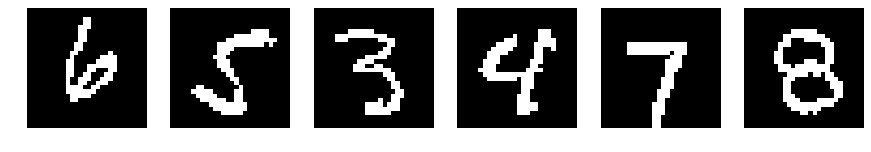

In [11]:
# Show some images
# f = plt.figure()
# f.add_subplot(1,2,1)
# plt.imshow(X_train[0][:,:,0], cmap='gray')
# plt.title(y_train[0])
# f.add_subplot(1,2,2)
# plt.imshow(X_train[1][:,:,0], cmap='gray')
# plt.title(y_train[1])
# plt.show()    
plot_size = 6
f = plt.figure(figsize=(15,15))
for i in range(plot_size):
    f.add_subplot(1,plot_size,i+1)
    plt.imshow(X_train[i][:,:,0], cmap='gray')
#     plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=15,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.2, # Randomly zoom image 5%
        width_shift_range=0.2,  # randomly shift images horizontally 5%
        height_shift_range=0.2,  # randomly shift images vertically 5%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
   
datagen.fit(X_train)

In [13]:
model = Sequential()

# 1
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation='relu', strides=(1,1), input_shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(padding='same', pool_size=(2,2)))
model.add(Dropout(0.2))

# 2
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding='same', strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(padding='same', pool_size=(4,4)))
model.add(Dropout(0.2))

# 3
model.add(Conv2D(filters = 128, kernel_size = (5,5), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(filters = 128, kernel_size = (5,5), padding='same', strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(padding='same', pool_size=(2,2)))
model.add(Dropout(0.2))


# fully connected
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

In [14]:
model.compile(optimizer = keras.optimizers.Adam() , loss = keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [15]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size = 32),
                              steps_per_epoch= len(X_train)//32,
                              epochs = 200,
                              validation_data = (X_val,y_val),
                              )

Epoch 1/200
1050/1050 [==============================] - 20s 19ms/step - loss: 0.5143 - accuracy: 0.8358 - val_loss: 0.1125 - val_accuracy: 0.9677
Epoch 2/200
1050/1050 [==============================] - 16s 15ms/step - loss: 0.1754 - accuracy: 0.9528 - val_loss: 0.1161 - val_accuracy: 0.9694
Epoch 3/200
1050/1050 [==============================] - 15s 15ms/step - loss: 0.1351 - accuracy: 0.9639 - val_loss: 0.0839 - val_accuracy: 0.9761
Epoch 4/200
1050/1050 [==============================] - 16s 15ms/step - loss: 0.1220 - accuracy: 0.9675 - val_loss: 0.0523 - val_accuracy: 0.9852
Epoch 5/200
1050/1050 [==============================] - 16s 15ms/step - loss: 0.1179 - accuracy: 0.9702 - val_loss: 0.0447 - val_accuracy: 0.9881
Epoch 6/200
1050/1050 [==============================] - 16s 15ms/step - loss: 0.1033 - accuracy: 0.9732 - val_loss: 0.0349 - val_accuracy: 0.9887
Epoch 7/200
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0952 - accuracy: 0.9759 - val_loss: 0

In [16]:
score, acc = model.evaluate(X_val, y_val)
print("Score:", score)
print("Acc:", acc)

8400/8400 [==============================] - 1s 105us/step
Score: 0.03215084367071886
Acc: 0.9939285516738892


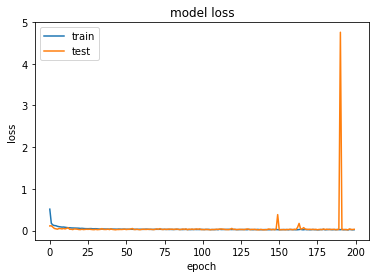

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Test Result
results = model.predict(test_data)
results = np.argmax(results, 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("CNN.csv",index=False)